In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("./data/merged_data.csv",index_col=0)

# Part 1: Data Analysis
## FP Growth Algorithm

In [3]:
# We start with the association rules
!pip install nltk pyfpgrowth scipy sklearn --quiet
import pyfpgrowth
import string
import nltk
from nltk import word_tokenize
nltk.download('punkt')
import numpy as np
from nltk.util import ngrams
from collections import Counter
printable = set(string.printable)
punct = '''!()-[]{};:'"\, <>./?@#क$%^&*_~…'ी'ा1234567890'''
words = ["and", "the", "to", "i", "with", "my", "is", "of", "it", "i", "be", "l", "ar", "ra", "you", "de", 'this', 'naughty', 'he',
         'th','for','in', 'on','la','he','was','but','will','we','but','a','so','no','list',
             'st', 'com'] + [" "+c+" " for c in "0123456789abcdefghijklmnopqrstuvwxyz"]

[nltk_data] Downloading package punkt to /home/aghriss/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Function for text cleaning
def unicode(text): return "".join([t for t in text if t in printable])
def remove_punct(text):
    punct = '''!()-[]{};:'"\, <>./?@#क$%^&*_~…'ी'ा1234567890'''
    for p in punct:
        text = text.replace(p," ")
    return text.replace("  "," ").lower()
def remove_easy_words(text):
    for w in words:
        text = text.replace(w," ")
    return text

In [5]:
# Replace nan values with string (empty cells are considered flaots)
df.text = df.text.fillna("")
df.text = df.text.map(unicode)
df.text = df.text.map(remove_punct)
text = "\n".join(list(df.text)) # merge all tweets
text = text.replace('''!()-[]{};:'"\, <>./?@#$%^&*_~''', " ") # remove punctuation

# Getting unigrams with frequencies
tokens = nltk.word_tokenize(text)
tokens = list(filter(lambda x : x.lower() not in words, tokens))
unigrams = dict(nltk.FreqDist((ngrams(tokens,1))))
unigrams_frequency = list(unigrams.items())
unigrams_frequency.sort(key=lambda x: -x[1])
unigram_2_index = {v[0]:k for k,v in enumerate(unigrams_frequency)}
index_2_unigram = {k:v[0] for k,v in enumerate(unigrams_frequency)}



In [6]:
# Choose label to get association rules for
LABEL = 0
# Getting unigrams from tweets for LABEL
tweets = list(df.text.fillna("")[df.trending==LABEL])

# Covnerts tweet text to item-set of unigrams
def text_to_items(text):
    text = text.replace('''!()-[]{};:'"\, <>./?@#$%^&*_~''', " ")
    tokens = list(ngrams(nltk.word_tokenize(text),1))
    items = [unigram_2_index[t] for t in tokens if t in unigram_2_index]
    return sorted(items)[:min(10,len(items))]

# set of tweets as item-sets
result = list(map(text_to_items, tweets))

# Using FP growth algorithm to find patterns and association rules
patterns = pyfpgrowth.find_frequent_patterns(result, 50)
rules = pyfpgrowth.generate_association_rules(patterns, 0.5)
# we reverse the rules from integers to words
def reverse_rule(rule):
    return [index_2_unigram[r] for r in rule]
reverse = [(reverse_rule(r),rules[r]) for r in rules]
#print top 5 association rules
print("TOP 5 association rules for label %i"%LABEL, end="\n\t")
print("\n\t".join( [ str(l) for l in list(sorted(reverse, key=lambda x: -x[1][1]))[:5]]))

TOP 5 association rules for label 0
	([('joy',), ('joy',), ('joy',)], ((1,), 4.7976190476190474))
	([('selector',), ('selector',), ('red',)], ((21,), 2.9622641509433962))
	([('crying',), ('crying',), ('loudly',)], ((1,), 2.830769230769231))
	([('heart',), ('heart',), ('red',)], ((38,), 2.7758620689655173))
	([('face',), ('face',), ('loudly',)], ((77,), 2.7246376811594204))


## Attribute Distribution

In [7]:
import matplotlib
import scipy.stats

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


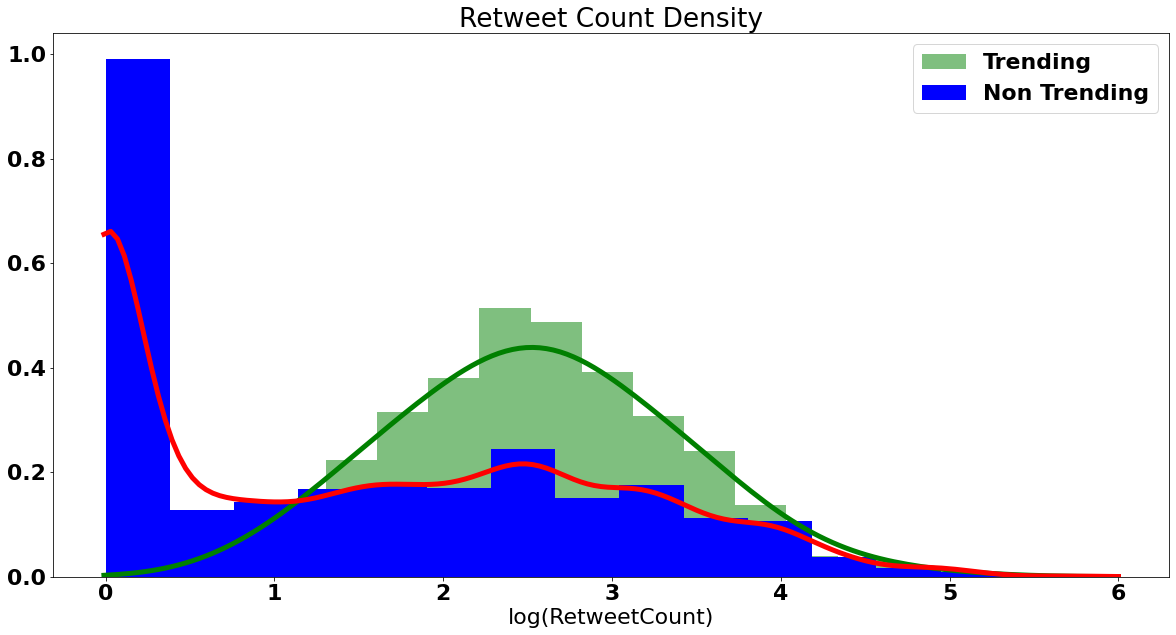

In [8]:

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
plt.figure(figsize=(20,10))
plt.title("Retweet Count Density")
values1 = np.log10(1+df[df.trending==1].retweetCount)
values0 = np.log10(1+df[df.trending==0].retweetCount)
plt.hist(values1, facecolor='green', alpha=0.5, label="Trending", bins=15, density=True)
plt.hist(values0, facecolor='blue', alpha=1.0, label="Non Trending", bins=15, density=True)
t_range = np.linspace(-0.01,6,150)
kde1 = scipy.stats.gaussian_kde(values1, bw_method=0.5)
kde0 = scipy.stats.gaussian_kde(values0, bw_method=0.15)
pdf1 = kde1(t_range)
pdf0 = kde1(t_range)

plt.plot(t_range,kde1(t_range),lw=5, color='green')
plt.plot(t_range,kde0(t_range),lw=5, color="red")
plt.xlabel(r"log(RetweetCount)")
plt.legend()


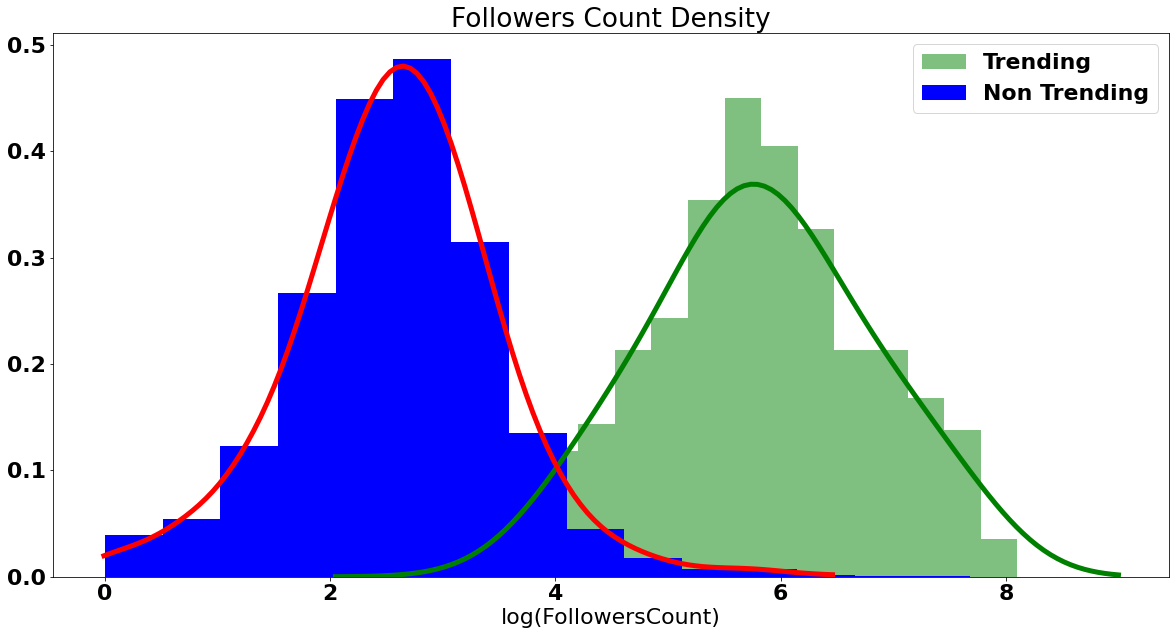

In [9]:
matplotlib.rc('font', **font)
plt.figure(figsize=(20,10))
plt.title("Followers Count Density")
values1 = np.log10(1+df[df.trending==1].userFollowersCount)
values0 = np.log10(1+df[df.trending==0].userFollowersCount)
plt.hist(values1, facecolor='green', alpha=0.5, label="Trending", bins=15, density=True)
plt.hist(values0, facecolor='blue', alpha=1.0, label="Non Trending", bins=15, density=True)
t_range = np.linspace(-0.01,9,150)
kde1 = scipy.stats.gaussian_kde(values1, bw_method=0.5)
kde0 = scipy.stats.gaussian_kde(values0, bw_method=0.3)
pdf1 = kde1(t_range[t_range>2])
pdf0 = kde0(t_range[t_range<6.5])

plt.plot(t_range[t_range>2],pdf1,lw=5, color='green')
plt.plot(t_range[t_range<6.5],pdf0,lw=5, color="red")
plt.xlabel(r"log(FollowersCount)")
plt.legend()


# Classifier training
## Data formatting

In [10]:
# Indices of non-trending tweets
non_trending = np.where(df.trending==0)[0]
# Indices of trending tweets
trending = np.where(df.trending==1)[0]
# We sample a number of random non-trending tweets equal to the number of trending tweets
non_trending = np.random.choice(non_trending, len(trending), replace=False)
# the indices to keep
indices = np.concatenate([trending,non_trending])
# final dataset with equal number of trending and non trending tweets
df = df.iloc[indices]

In [11]:
# We transform categorical sources to integers
df.source = df.source.map({"UNKNOWN":0,"ANDROID":1,"IPHONE":2,"WEB":3})
# we drop text and userId
df.drop(['text', 'userId'],axis=1, inplace=True)
# Tranform booleans to binaries
df = df*1.0
df.head()

,retweetCount,likeCount,isQuote,source,userFollowersCount,userVerified,userProtected,userFriendsCount,userStatusesCount,userListedCount,...,feat_1,feat_2,feat_3,feat_4,flair_sentiment,flair_fast_sentiment,polarity,polarity_positive,polarity_negative,polarity_compound
0,2999.0,12112.0,1.0,3.0,505260.0,1.0,0.0,2430.0,106058.0,5090.0,...,0.003181,0.005748,0.007677,0.008153,-0.988184,-0.613305,-0.30,0.053,0.102,-0.2732
1,1444.0,4737.0,0.0,3.0,356683.0,1.0,0.0,188732.0,121553.0,2863.0,...,0.000651,0.002455,0.006061,0.015629,-0.608752,-0.940426,0.00,0.125,0.114,-0.1779
2,1046.0,3310.0,0.0,3.0,66242.0,1.0,0.0,61524.0,217931.0,1303.0,...,0.000726,0.001803,0.003193,0.003481,-0.801528,0.556271,0.15,0.228,0.149,0.3182
3,716.0,2738.0,0.0,3.0,66242.0,1.0,0.0,61524.0,217931.0,1303.0,...,0.033437,0.051170,0.051183,0.082353,0.593407,0.632129,0.05,0.000,0.000,0.0000
4,77.0,405.0,0.0,3.0,110686.0,1.0,0.0,976.0,75142.0,509.0,...,0.002830,0.004821,0.005748,0.014277,-0.998076,0.528218,0.45,0.173,0.000,0.5267


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display, Markdown


In [13]:
def train_classifier(train_attrb):
  # trains Random Forest Classifier 
  f1_runs = []
  acc_runs = []
  for _ in range(10):
    scaler = StandardScaler()
    randfor = RandomForestClassifier(n_estimators=200, criterion="entropy")



    train_x = scaler.fit_transform(df[train_attrb])
    X_train, X_test, y_train, y_test = train_test_split(train_x, df.trending,
                                                        test_size=0.33, random_state=42)
    randfor.fit(X_train, y_train)
    from sklearn.metrics import roc_auc_score, f1_score
    #y_proba = logreg.predict_proba(X_test)
    #print("ROC AUC", roc_auc_score(np.eye(2)[np.array(y_test).astype(int)],y_proba))
    #y_test_pred = logreg.predict(X_test)
    #print("F1 score %f"%f1_score(y_test, y_test_pred))

    y_proba = randfor.predict_proba(X_test)
    #print("ROC AUC", roc_auc_score(np.eye(2)[np.array(y_test).astype(int)],y_proba))
    y_test_pred = randfor.predict(X_test)
    f1_runs.append(f1_score(y_test, y_test_pred))
    acc_runs.append(randfor.score(X_test,y_test))
    #target_attrb = ['retweetCount', 'likeCount', 'trending']
    #logreg = LogisticRegression()

  display(Markdown(rf"F1 score : %.3f $\pm$ %.3f"%(np.mean(f1_runs),np.std(f1_runs))))
  display(Markdown(rf"Accuracy : %.2f $\pm$ %.2f"%(np.mean(acc_runs)*100,100*np.std(acc_runs))))

In [14]:
train_attrb = ['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4']
print("Bigrams Attributes:")
train_classifier(train_attrb)


Bigrams Attributes:


F1 score : 0.620 $\pm$ 0.008

Accuracy : 61.19 $\pm$ 0.66

In [15]:
train_attrb = [
      #'isQuote',
      #'source',
      #'userFollowersCount',
      #'userVerified',
      #'userProtected',
      #'userFriendsCount',
      #'userStatusesCount', 
      #'userListedCount', 
      #'userOnTwitter(Months)',
      #'feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4',
      'flair_sentiment', 'flair_fast_sentiment', 'polarity',
      'polarity_positive', 'polarity_negative', 'polarity_compound'
      ]
print("Sentiement Attributes:")
train_classifier(train_attrb)

Sentiement Attributes:


F1 score : 0.599 $\pm$ 0.006

Accuracy : 59.76 $\pm$ 0.69

In [16]:
train_attrb = ['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4',
      'flair_sentiment', 'flair_fast_sentiment', 'polarity',
      'polarity_positive', 'polarity_negative', 'polarity_compound'
      ]
print("Sentiment and Bigram Attributes:")
train_classifier(train_attrb)


Sentiment and Bigram Attributes:


F1 score : 0.621 $\pm$ 0.006

Accuracy : 61.42 $\pm$ 0.43

In [17]:
train_attrb = [
      'isQuote',
      'source',
      'feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4',
      'flair_sentiment', 'flair_fast_sentiment', 'polarity',
      'polarity_positive', 'polarity_negative', 'polarity_compound'
      ]
print("Sentiment, Bigram, and Tweet Context Attributes:")
train_classifier(train_attrb)

Sentiment, Bigram, and Tweet Context Attributes:


F1 score : 0.749 $\pm$ 0.005

Accuracy : 74.31 $\pm$ 0.50

In [18]:
train_attrb = [
      'isQuote',
      'source',
      'userStatusesCount',  
      'userOnTwitter(Months)',
      'feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4',
      'flair_sentiment', 'flair_fast_sentiment', 'polarity',
      'polarity_positive', 'polarity_negative', 'polarity_compound'
      ]
print("All Attributes:")
train_classifier(train_attrb)

All Attributes:


F1 score : 0.812 $\pm$ 0.005

Accuracy : 80.79 $\pm$ 0.51

In [19]:
train_attrb = [
      'isQuote',
      'source',
      'userFollowersCount',
      'userVerified',
      #'userProtected',
      #'userFriendsCount',
      'userStatusesCount', 
      'userListedCount', 
      'userOnTwitter(Months)',
      'feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4',
      'flair_sentiment', 'flair_fast_sentiment', 'polarity',
      'polarity_positive', 'polarity_negative', 'polarity_compound'
      ]
print("Attributes with label leaked ")
train_classifier(train_attrb)

Attributes with label leaked 


F1 score : 0.993 $\pm$ 0.000

Accuracy : 99.26 $\pm$ 0.00